In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import json
import csv
import os
import string
import collections

from scipy.stats import zscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [2]:
business = pd.read_csv("/home/kai/yelp_dataset/business.csv")
review_all = pd.read_csv("/home/kai/yelp_dataset/review.csv")

In [3]:
business.head()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  stars  review_count  is_open  \
0  33.330690 -111.978599    4.0            22        1   
1  40.291685  -80.104900    3.0            11        1   
2  33.524903 -112.115310    1.5            18        1   
3  33.383147 -111.964725    3.0             9        0   
4  41.119535  -81.475690    3.5           116        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

In [4]:
review_all.head()

review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   
2  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   
3  IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw  ACFtxLv8pGrrxMm6EgjreA   
4  L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw  s2I_Ni76bjJNK9yG60iD-Q   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   
2      5  2016-05-28  Lester's is located in a beautiful neighborhoo...   
3      4  2016-05-28  Love coming here. Yes the place always needs t...   
4      4  2016-05-28  Had their chocolate almond croissant and it wa...   

   useful  funny  cool  
0       0      0     0  
1       0      0     0  
2       0      0     0  
3       0      0     0  
4       0      0     0

In [5]:
a = business[business['categories'].str.contains('Restaurant') == True]
rev = review_all[review_all.business_id.isin(a['business_id']) == True]

In [6]:
rev_samp = rev.sample(n = 350000, random_state=42)
train = rev_samp[0:280000]
test = rev_samp[280000:]

In [7]:
train.shape, test.shape

((280000, 9), (70000, 9))

text  stars
2760442  Second time here.... first time had the pulled...      5
3014452  Great place. Like their sauce and lunch specia...      5
2876979  So goooooooood and so simple! I love their pel...      5
469097   We stopped in for a late lunch on a Tuesday af...      3
4971248  A great option to try hakka chinese since its ...      4

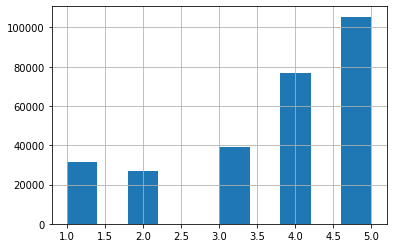

In [8]:
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [9]:
train = pd.get_dummies(train, columns=['stars'])
train.head()

text  stars_1  stars_2  \
2760442  Second time here.... first time had the pulled...        0        0   
3014452  Great place. Like their sauce and lunch specia...        0        0   
2876979  So goooooooood and so simple! I love their pel...        0        0   
469097   We stopped in for a late lunch on a Tuesday af...        0        0   
4971248  A great option to try hakka chinese since its ...        0        0   

         stars_3  stars_4  stars_5  
2760442        0        0        1  
3014452        0        0        1  
2876979        0        0        1  
469097         1        0        0  
4971248        0        1        0

In [10]:
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns=['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

In [11]:
train_samp = train.sample(frac = .1, random_state=42)
test_samp = test.sample(frac = .1, random_state=42)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

In [12]:
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [13]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x,1,y)/self.pr(x,0,y)))
        return self
    
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb
            

In [14]:
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [15]:
import sklearn
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_names in enumerate(class_names):
    train_target = train_samp[class_names]
    cv_score = np.mean(sklearn.model_selection.cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_names, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]
    

CV score for class stars_1 is 0.9282499819604656
CV score for class stars_2 is 0.90339283521352
CV score for class stars_3 is 0.8591786654537303
CV score for class stars_4 is 0.7321071676830603
CV score for class stars_5 is 0.8044644727087923


In [16]:
train['text'][4971248]

'A great option to try hakka chinese since its halal! We had cantonese chow mein, chicken 88 and spicy fish with vegetable stir fry rice and that was all enough for four people to eat! Beware, their portion sizes are huge and that will be your only complaint! For those that like mild spices though, you will have to ask them to keep it mild!'

In [18]:
embed_size = 200
max_features = 20000
maxlen = 200

embedding_file = '/home/kai/yelp_dataset/glove.twitter.27B.200d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [19]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
y = train_samp[class_names].values

In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['text'].values)
x_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)

In [21]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words,embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [22]:
len(missed)

2147

In [23]:
missed[0:10]

["it's", "don't", "i'm", "i've", "didn't", '5', '2', '3', "wasn't", '4']

In [24]:
missed[1000:1010]

["lobby's",
 "capo's",
 "'fast",
 'gratuities',
 "owners'",
 'brasseurs',
 'mittagszeit',
 "soup'",
 "pauly's",
 "flo's"]

In [26]:
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation='sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
earlystop = EarlyStopping(monitor='var_loss', min_delta=0, patience=3)
checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.fit(x_train, y, batch_size=512,epochs=20, validation_split=.1,callbacks=[earlystop,checkpoint])

Epoch 1/20
50/50 [==============================] - 53s 979ms/step - loss: 0.5011 - accuracy: 0.3625 - val_loss: 0.4613 - val_accuracy: 0.3825
Epoch 2/20
50/50 [==============================] - 48s 960ms/step - loss: 0.4448 - accuracy: 0.4001 - val_loss: 0.4278 - val_accuracy: 0.4179
Epoch 3/20
50/50 [==============================] - 47s 939ms/step - loss: 0.3944 - accuracy: 0.4847 - val_loss: 0.3633 - val_accuracy: 0.5361
Epoch 4/20
50/50 [==============================] - 47s 941ms/step - loss: 0.3578 - accuracy: 0.5417 - val_loss: 0.3468 - val_accuracy: 0.5564
Epoch 5/20
50/50 [==============================] - 47s 941ms/step - loss: 0.3391 - accuracy: 0.5704 - val_loss: 0.3290 - val_accuracy: 0.5861
Epoch 6/20
50/50 [==============================] - 47s 933ms/step - loss: 0.3263 - accuracy: 0.5923 - val_loss: 0.3246 - val_accuracy: 0.5925
Epoch 7/20
50/50 [==============================] - 47s 931ms/step - loss: 0.3153 - accuracy: 0.6099 - val_loss: 0.3168 - val_accuracy: 0.6057

In [28]:
y_test = model.predict([x_test], batch_size=1024, verbose=1)

7/7 [==============================] - 5s 591ms/step


In [29]:
model.evaluate(x_test, test_samp[class_names].values, verbose=1,batch_size=1024)

7/7 [==============================] - 4s 587ms/step - loss: 0.3337 - accuracy: 0.6137


[0.33372732996940613, 0.6137142777442932]

In [30]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       771
           1       0.44      0.35      0.39       687
           2       0.52      0.43      0.47      1020
           3       0.53      0.53      0.53      1906
           4       0.74      0.76      0.75      2616

    accuracy                           0.61      7000
   macro avg       0.57      0.57      0.57      7000
weighted avg       0.61      0.61      0.61      7000



In [31]:
model.save('nn_model.h5')